In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [66]:
DATA = Path().cwd().parent / 'common_data'
PLOTS = Path.cwd().parent / 'plots'

# Font size of plots
plt.rcParams['font.size'] = 18

# Building Demand in GCAM
The following is my attempt to follow GCAM's method for calculating energy demand for buildings

### Constants

In [99]:
# Satiation level of floor space demand (I chose these based off the historical data)
S_FS_R = 65
S_FS_C = 24

# Price elasticity of energy services (all GCAM provides for the building sector is 'Fuel preference elasticies', so I averaged those)
BETA_R = -0.630769230769231
BETA_C = -0.381818181818182

# Ratio of building surface area to floorspace area (no idea about this one, 
# I simply did (4 walls + 1 ceiling + 1 floor)/1 floor, considering all to be the same area (which is ridiculous but whatever)
R = 6

# Historical years
HIST_YEARS = list(range(2000, 2019))

# Projection time horizon (5 year steps)
PROJ_YEARS = list(range(2020, 2101, 5))

### Import data from excel sheet
This includes historical data for residential and commercial floor space, as well as data for residential/commercial space heating/cooling

In [6]:
gdp_pop_data = pd.read_excel(DATA / 'gdp_pop.xlsx',
                            sheet_name = 'data',
                            usecols = ['region', 'variable', 'year', 'value', 'unit'])
gdp_pop_data.set_index(['variable', 'year'], inplace = True)
gdp_pop_data = gdp_pop_data[['value', 'unit']]

In [63]:
data = pd.read_excel('data.xlsx',
                     sheet_name = 'data',
                     usecols = ['region', 'variable', 'year', 'value', 'unit'])
data.set_index(['variable', 'year'], inplace = True)
data = data[['value', 'unit']]

# Import historical floorspace demand data
res_floor_hist = data.loc['res_floor_demand'].copy()
com_floor_hist = data.loc['com_floor_demand'].copy()

# Import historical space heating and cooling demand data
res_heat_hist = data.loc['res_heat_intensity'].copy()
res_cool_hist = data.loc['res_cool_intensity'].copy()
com_heat_hist = data.loc['com_heat_intensity'].copy()
com_cool_hist = data.loc['com_cool_intensity'].copy()

# Income
income_hist = gdp_pop_data.loc['income_hist'].copy()
income_hist = income_hist.loc[HIST_YEARS]
income_proj = gdp_pop_data.loc['income_proj'].copy()
income_proj = income_proj.loc[PROJ_YEARS]

## Historical Plotting

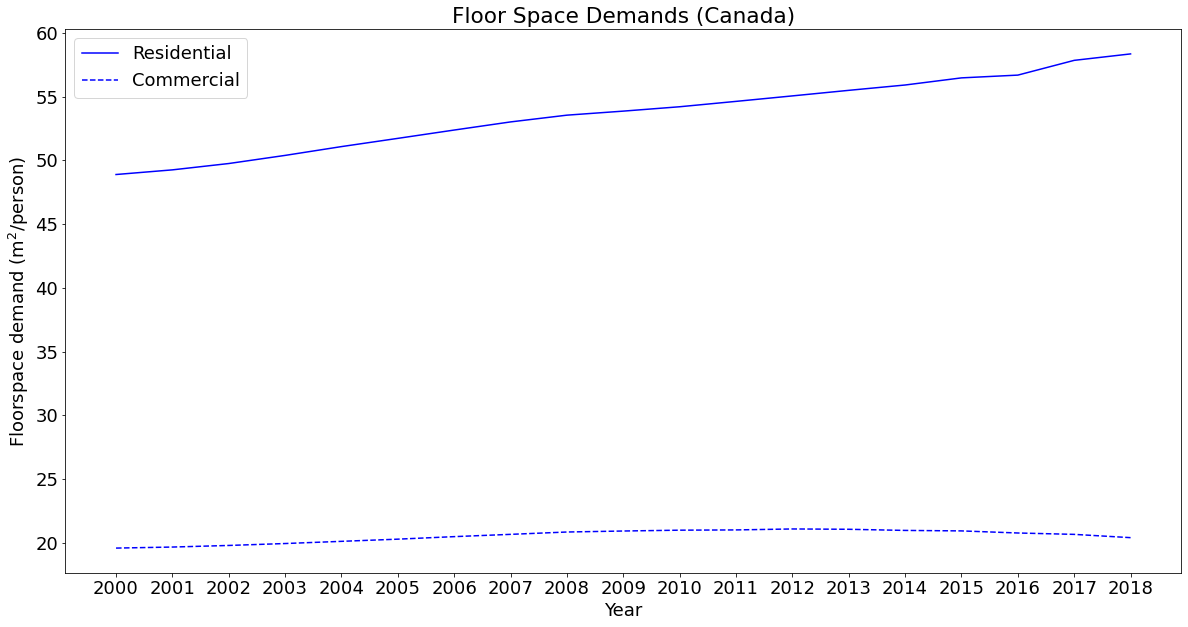

In [25]:
# Want to plot both residential and commercial historical demand here
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xticks(HIST_YEARS)
ax.plot(HIST_YEARS, res_floor_hist['value'],
        label = 'Residential',
        c = 'blue')
ax.plot(HIST_YEARS, com_floor_hist['value'],
        label = 'Commercial',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(title = 'Floor Space Demands (Canada)',
       xlabel = 'Year',
       ylabel = 'Floorspace demand (m$^2$/person)');

In [ ]:
fig, ax = plt.subplots(figsize = (10, 12))
ax.set_xticks(HIST_YEARS)
ax.plot(HIST_YEARS, res_heat_hist['value'],
        label = 'Residential Space Heating',
        c = 'red')
ax.plot(HIST_YEARS, res_cool_hist['value'],
        label = 'Residential Space Cooling',
        c = 'blue')
ax.plot(HIST_YEARS, com_heat_hist['value'],
        label = 'Commercial Space Heating',
        c = 'red',
        ls = '--')
ax.plot(HIST_YEARS, com_cool_hist['value'],
        label = 'Commercial Space Cooling',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(title = 'Building Service Demands (Canada)',
       xlabel = 'Year',
       ylabel = 'Service Demand per unit floorspace (GJ/m$^2$)');

## Base year calibration
For simplicity's sake I assume negligible change between 2018 and 2020, and use 2018 values for my 2020 base projection year

### Floor space

In [40]:
res_floor2018 = res_floor_hist.loc[2018].value
com_floor2018 = com_floor_hist.loc[2018].value

### Residential/Commercial Service Demands

In [41]:
res_heat2018 = res_heat_hist.loc[2018].value
res_cool2018 = res_cool_hist.loc[2018].value
com_heat2018 = com_heat_hist.loc[2018].value
com_cool2018 = com_cool_hist.loc[2018].value

### Internal Gains
Clarke et al: "Internal gains are calculated in each region as 50% of the sum of all fuel consumption used for 'other' (not heating or cooling) services

In [43]:
res_ig = data.loc['res_other_intensity/2'].copy()
com_ig = data.loc['com_other_intensity/2'].copy()

IG_R2018 = res_ig.loc[2018].value
IG_C2018 = com_ig.loc[2018].value
                      
# Since the internal gain scaler is not specified in
# Clarke et al, I used the number of summer and winter months to find it
# Summer months: [May: August] inclusive
# Winter months: [November:February] inclusive
# So, ratio of summmer months to total = 1/3
# and ratio of winter to total = 1/3
# So when space cooling is calculated, IG applies 1/3 of the time (summer months)
# Same for space heating

### Shell Conductivity (U-value)
Given in Fig S3 of Clarke et al

In [109]:
eta = pd.Series(np.linspace(0.95, 0.7, len(PROJ_YEARS)),
                index = PROJ_YEARS)

### HDD/CDD
Start with reference scenario, in which HDD and CDD do not change over the model horizon

In [46]:
HDD = 4300
CDD = 200

### Satiated demand
"The satiation level is assumed to be the maximum of the actual observed base-year demand levels, and the satiation level in the USA for the corresponding sector and service, modified for the HDD/CDD difference" (pp. 10 of supplementary to Clarke et al)

In [47]:
S_CAN = lambda S_USA, DD_CAN, DD_USA: S_USA*(DD_CAN/DD_USA)

# HDD/CDD collected from pp. 672
HDD_USA = 2500
CDD_USA = 800

# Satiation levels collected from pp. 11 of supplementary
S_USA_RH = 0.24
S_USA_CH = 0.25
S_USA_RC = 0.16
S_USA_CC = 0.29

# Residential heating
S_RH = max(res_heat2018, S_CAN(S_USA_RH, HDD, HDD_USA))

# Residential cooling
S_RC = max(res_cool2018, S_CAN(S_USA_RC, CDD, CDD_USA))
           
# Commercial heating
S_CH = max(com_heat2018, S_CAN(S_USA_CH, HDD, HDD_USA))
           
# Commercial cooling
S_CC = max(com_cool2018, S_CAN(S_USA_CC, CDD, CDD_USA))

### Find K

In [48]:
# 1/3 is my internal gain scaler, detailed above in 'Internal Gains' section
K = lambda S, DD, IG : S/(DD*eta[0]*R*1/3*IG)

In [49]:
# Res heat
K_RH = K(S_RH, HDD, IG_R2018)

# Res cool
K_RC = K(S_RC, CDD, IG_R2018)

# Com heat
K_CH = K(S_CH, HDD, IG_C2018)

# Com cool
K_CC = K(S_CC, CDD, IG_C2018)

In [73]:
p_res_heat = pd.Series([20*deflation_factor]*len(PROJ_YEARS),
                       index = PROJ_YEARS)

### Energy service price averages
Fig 6 (pp. 674)

In [89]:
## Both residential and commerical space heating are assumed to be relatively constant over the projection range

# Convert 2010 USD to 2005 USD
deflation_factor = 1/1.13

# Create pandas series to hold prices
p_res_heat = pd.Series([20*deflation_factor]*len(PROJ_YEARS),
                       index = PROJ_YEARS)
p_res_cool = pd.Series(np.zeros(len(PROJ_YEARS)),
                       index = PROJ_YEARS)
p_com_heat = pd.Series([28*deflation_factor]*len(PROJ_YEARS),
                       index = PROJ_YEARS)
p_com_cool = pd.Series(np.zeros(len(PROJ_YEARS)),
                       index = PROJ_YEARS)

# Residential
# 5-year rate of change for residential space cooling
res_cool_rate = (1 - 0.22)**(1/len(PROJ_YEARS))

# Commercial
# 5-year rate of change for commercial space cooling
com_cool_rate = (1 - 0.28)**(1/len(PROJ_YEARS))

# Initial values from Fig. 6 in Clarke et al.
p_res_cool[2020] = 38*deflation_factor
p_com_cool[2020] = 22.5*deflation_factor

# Generate cooling trajectories
for year in PROJ_YEARS[1:]:
    p_res_cool.loc[year] = p_res_cool.loc[year - 5] * res_cool_rate
    p_com_cool.loc[year] = p_com_cool.loc[year - 5] * com_cool_rate

p_res = p_res_heat + p_res_cool
p_com = p_com_heat + p_com_cool

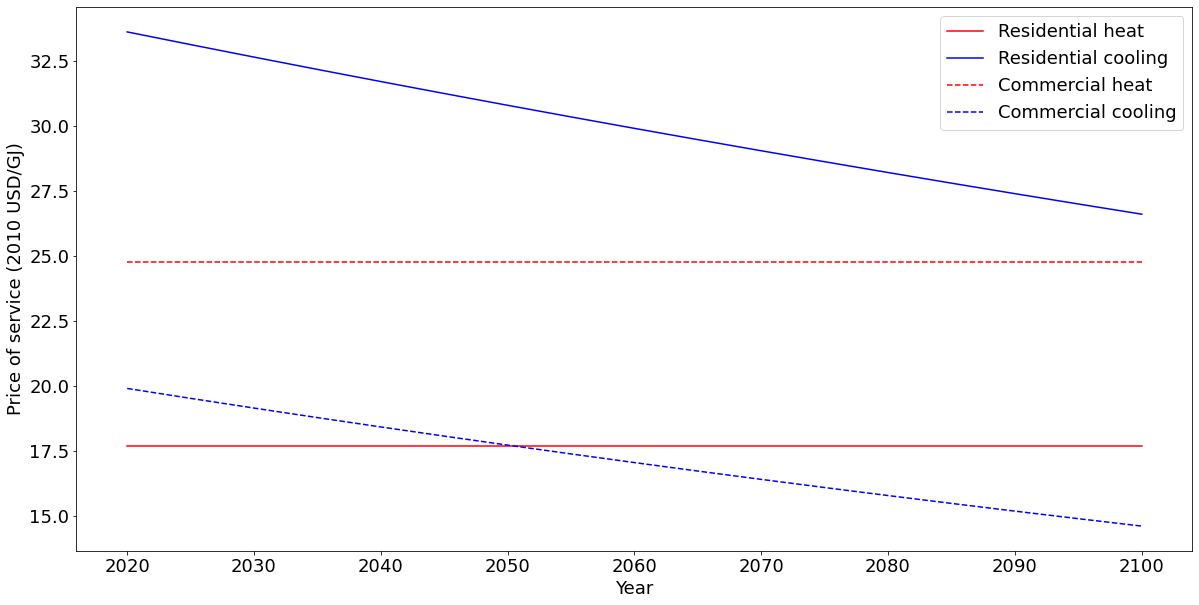

In [80]:
# Plot of prices
fig, ax = plt.subplots(figsize = (20, 10))
# ax.plot(proj_years, p_res_heat)
ax.plot(PROJ_YEARS, p_res_heat, color = 'r', label = 'Residential heat')
ax.plot(PROJ_YEARS, p_res_cool, color = 'b', label = 'Residential cooling')
ax.plot(PROJ_YEARS, p_com_heat, linestyle = '--', color = 'r', label = 'Commercial heat')
ax.plot(PROJ_YEARS, p_com_cool, linestyle = '--', color = 'b', label = 'Commercial cooling')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Price of service (2010 USD/GJ)');

In [81]:
fig.savefig(PLOTS / 'gcam_energy_prices.png')

### Find mu

In [82]:
income2018 = income_hist.loc[2018].value

mu = lambda p, d, K, DD, IG : -(np.log(2)*income2018)/(p*np.log(1-(d/(K*((DD*eta[0]*R)-(IG/3))))))

MU_RH = mu(p_res_heat[2020], res_heat2018, K_RH, HDD, IG_R2018)
MU_RC = mu(p_res_cool[2020], res_cool2018, K_RC, CDD, IG_R2018)
MU_CH = mu(p_com_heat[2020], com_heat2018, K_CH, HDD, IG_C2018)
MU_CC = mu(p_com_cool[2020], com_cool2018, K_CC, CDD, IG_C2018)

## Projections

### Floor space

In [100]:
# First we find mu (income at 50% of satiation)
mu_r = -(np.log(2)*income2018)/np.log(1 - res_floor2018/S_FS_R)
mu_c = -(np.log(2)*income2018)/np.log(1 - com_floor2018/S_FS_C)

# Function for calculating floor space demand given in GCAM docs
FS = lambda S, MU, I, P, P_0, BETA : (S - a) * ((1 - np.exp(-(np.log(2)/MU) * I * (P/P_0)**BETA)) + a)

res_floor_proj = pd.Series(np.zeros(len(PROJ_YEARS)),
                           index = PROJ_YEARS)
com_floor_proj = pd.Series(np.zeros(len(PROJ_YEARS)),
                           index = PROJ_YEARS)

a = 0

for year in PROJ_YEARS:
    res_floor_proj[year] = FS(S_FS_R, mu_r, income_proj.loc[year].value, p_res[year], p_res[2020], BETA_R)
    com_floor_proj[year] = FS(S_FS_C, mu_c, income_proj.loc[year].value, p_com[year], p_com[2020], BETA_C)

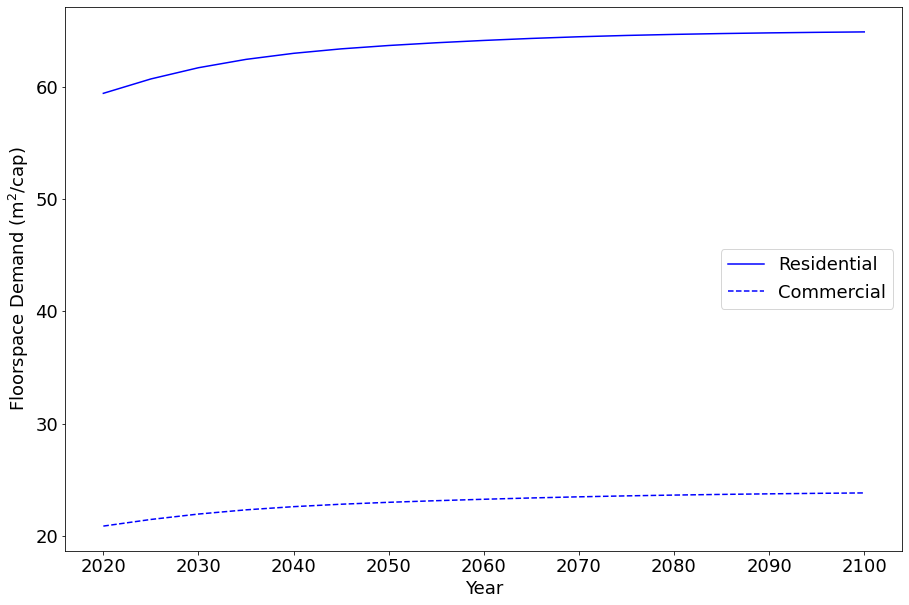

In [107]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(PROJ_YEARS,
       res_floor_proj,
       label = 'Residential',
       c = 'blue')
ax.plot(PROJ_YEARS,
        com_floor_proj,
        label = 'Commercial',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Floorspace Demand (m$^2$/cap)');

In [108]:
fig.savefig(PLOTS / 'gcam_floorspace_projection.png')

### Space heating/cooling

In [118]:
D = lambda K, DD, eta, IG, I, MU, p: K*((DD*eta*R)-(IG/3))*(1-np.exp(-(np.log(2)*I)/(MU*p)))

res_heat_proj = pd.Series(np.zeros(len(PROJ_YEARS)),
                          index = PROJ_YEARS)
res_cool_proj = pd.Series(np.zeros(len(PROJ_YEARS)),
                          index = PROJ_YEARS)
com_heat_proj = pd.Series(np.zeros(len(PROJ_YEARS)),
                          index = PROJ_YEARS)
com_cool_proj = pd.Series(np.zeros(len(PROJ_YEARS)),
                          index = PROJ_YEARS)

for i, year in enumerate(PROJ_YEARS):
    res_heat_proj[year] = D(K_RH, HDD, eta[year], IG_R2018, income_proj.loc[year].value, MU_RH, p_res_heat[year])
    res_cool_proj[year] = D(K_RC, CDD, eta[year], IG_R2018, income_proj.loc[year].value, MU_RC, p_res_cool[year])
    com_heat_proj[year] = D(K_CH, HDD, eta[year], IG_C2018, income_proj.loc[year].value, MU_CH, p_com_heat[year])
    com_cool_proj[year] = D(K_CC, CDD, eta[year], IG_C2018, income_proj.loc[year].value, MU_CC, p_com_cool[year])

### Plotting

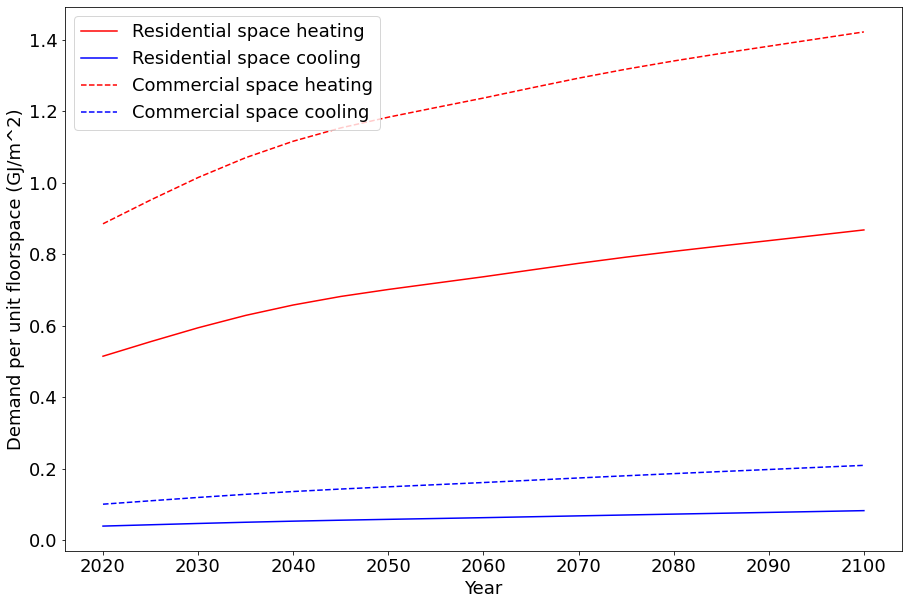

In [127]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(PROJ_YEARS, res_heat_proj, label = 'Residential space heating',
        c = 'red',
        )
ax.plot(PROJ_YEARS, res_cool_proj, label = 'Residential space cooling',
        c = 'blue')
ax.plot(PROJ_YEARS, com_heat_proj, label = 'Commercial space heating',
        c = 'red',
        ls = '--')
ax.plot(PROJ_YEARS, com_cool_proj, label = 'Commercial space cooling',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Demand per unit floorspace (GJ/m^2)');

In [129]:
fig.savefig(PLOTS / 'gcam_service_demand_projection')

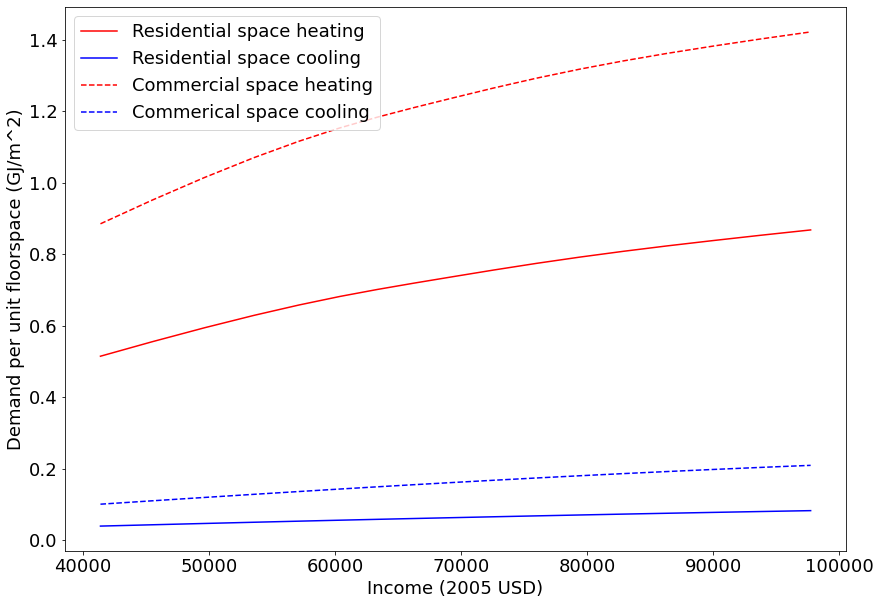

In [125]:
# Versus income
fig, ax = plt.subplots(figsize = (14, 10))
ax.plot(income_proj['value'], res_heat_proj,
        label = 'Residential space heating',
        c = 'red')
ax.plot(income_proj['value'], res_cool_proj,
        label = 'Residential space cooling',
        c = 'blue')
ax.plot(income_proj['value'], com_heat_proj,
        label = 'Commercial space heating',
        c = 'red',
        ls = '--')
ax.plot(income_proj['value'], com_cool_proj,
        label = 'Commerical space cooling',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(xlabel = 'Income (2005 USD)',
       ylabel = 'Demand per unit floorspace (GJ/m^2)');
fig.savefig('Service Demand vs Income.png')

# Testing

In [ ]:
elas = pd.read_csv('elasticities.csv',
                   index_col = ['sector', 'technology'])

In [ ]:


elas.loc[()]

In [ ]:
elas.groupby(level = 'sector').mean()

# OLD CODE

In [ ]:
# Historical
income_hist_list = income_hist[income_hist['year'] <= 2015]['value'].tolist()
res_floor_hist_list = res_floor_hist[res_floor_hist['year'] <= 2015]['value'].tolist()
com_floor_hist_list = com_floor_hist[com_floor_hist['year'] <= 2015]['value'].tolist()
fig, ax = plt.subplots(figsize = (8, 10))
ax.plot(income_hist_list, res_floor_hist_list, color = 'blue', label = 'Residential floor space demand')
ax.plot(income_hist_list, com_floor_hist_list, color = 'orange', label = 'Commercial floor space demand')
plt.legend()
plt.show()

# Projection
income_proj_list = income_proj['value'].tolist()
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(income_proj_list, res_floor_proj, color = 'blue', label = 'Residential floor space projection')
ax.scatter(income_proj_list, res_floor_proj, color = 'black')
ax.plot(income_proj_list, com_floor_proj, color = 'orange', label = 'Commercial floor space projection')
ax.scatter(income_proj_list, com_floor_proj, color = 'black')
for i, label in enumerate(proj_years):
    plt.annotate(label, (income_proj_list[i], com_floor_proj[i]))
plt.xlabel('Income (2015USD/cap)')
plt.ylabel('Residential floor space demand (m^2/cap)')
plt.legend()
plt.show()

In [ ]:
### Service demand for each technology

tech_costs = pd.read_csv('building_costs.csv',
                        usecols = ['sector|supplysector', 'technology', 'installed cost (2015 USD)', 'lifetime', 'O&M cost (2015 USD)', 'efficiency', 'UEC'],
                        ).rename(columns = {'sector|supplysector': 'sector|service'})

# Index by sector|service
tech_costs = tech_costs.set_index(['sector|service', 'technology']).sort_index()

# Multiplying efficiency and consumption to find tech service demands
tech_costs['service demand'] = tech_costs['efficiency'] * tech_costs['UEC']

# Aggregate data for each sector|service combination
indices = list(tech_costs.index)
services = set([x[0] for x in indices])
sums = [x for x in tech_costs.columns if x != 'lifetime' and x != 'efficiency']

for x in services:
    tech_costs.loc[(x, 'all'), sums] = tech_costs.loc[(x, slice(None)), sums].sum()

tech_costs.sort_index(inplace = True)

tech_costs

tech_costs.loc[(slice(None), 'all'),'service demand']